
author: EdgardoCS @FSU Jena
date: 04-06-2025


In [37]:
import math
import time

import numpy as np
from PIL import Image
from matplotlib import cm
import scipy.stats as stats
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [38]:
def count_match(input1, input2):
    """
    Takes two images in array format, determines where there is activation (a-band values) and
    calculates the % of match between the two images.
    :param input1: Image 1 in array format
    :param input2: Image 2 in array format
    :return: % of match between the two images
    """
    pixels = input1.shape[0] * input1.shape[1]

    arr1_pixels = 0
    arr2_pixels = 0
    any_pixel = 0
    n_match = 0
    for i in range(0, input1.shape[0]):
        for j in range(0, input1.shape[1]):
            # First, let see how many pixels have value in array 1
            if input1[i, j][3] != 0:
                arr1_pixels += 1
            # Let's do the same for array 2
            if input2[i, j][3] != 0:
                arr2_pixels += 1
            # Now, check whereas any of the two images has pixels
            if input1[i, j][3] != 0 or input2[i, j][3] != 0:
                any_pixel += 1
            # Finally, let's see where the meet
            if input1[i, j][3] != 0 and input2[i, j][3] != 0:
                n_match += 1
    #print("% of pixels with information in image 1", f' {(arr1_pixels * 100 / pixels):.2f}%')
    #print("% of pixels with information in image 2", f' {(arr2_pixels * 100 / pixels):.2f}%')

    total_match = n_match * 100 / any_pixel

    return total_match

In [39]:
def plot_heatmap(image_map1, image_map2, outline, name):
    """
    Plot the difference map between all images, uses absolute differences array as input.
    Numpy stack allow us to plot both arrays side by side without merging with PIL, which seems
    to delete the A-Band channel, which is our target channel.
    :param image_map1: Array of pixels from Image 1
    :param image_map2: Array of pixels from Image 2
    :param outline: Body outline in png format
    :param name: Output file name
    :return: Nothing
    """

    front_and_back = np.hstack((image_map1, image_map2))
    resized_arr = zoom(front_and_back, (1, 400 / 800), order=1)  # Scale width only

    plt.figure(1)
    plt.imshow(resized_arr, cmap='Reds', interpolation='nearest')
    plt.colorbar(label="Touch intensity")
    plt.imshow(outline)
    plt.savefig(output_name, format='png')
    plt.show()

In [40]:
def calculate_t(input1, input2):
    """
    from pixel-arrays calculates the statistical one-sample t test using stats library.
    Population mean is defined as 0
    :param input1: pixel 1
    :param input2: pixel 2
    :return: t and p values from ttest[statistic,pvalue]
    """
    ttest = stats.ttest_1samp([input1, input2], popmean=0.0)
    t = ttest.statistic
    p = ttest.pvalue

    return t, p

In [41]:
def plot_t_p_map(image_map, pvalues_map, body_image, x_axis, y_axis):
    """
    Plots the wireframe map of the t-values. A threshold can be used to set the significant values following
    t-distribution table from https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf
    x-axis: evenly spaced samples with length of the width dimension of the input array
    y-axis: evenly spaced samples with length of the height dimension of the input array
    z-axis: t-map values from calculate_t function below
    :param image_map: t-values map
    :param pvalues_map: p-values map
    :param body_image: Body outline in png format
    :param x_axis: size (int) of target width
    :param y_axis: size (int) of target height
    :return: Nothing
    """
    z = image_map  # Use the values directly as height

    z_significant = np.where(z < 12.71, np.nan, z)
    nx = x_axis
    ny = y_axis
    x1 = np.linspace(0, 10, ny)
    y1 = np.linspace(0, 10, nx)
    x, y = np.meshgrid(x1, y1)

    nan_mask = np.isnan(pvalues_map)
    valid_p_values = pvalues_map[~nan_mask]

    rejected, pvals_corrected_valid, _, _ = multipletests(valid_p_values, alpha=0.05, method='fdr_bh')
    pvals_corrected = np.full_like(pvalues_map, np.nan, dtype=np.float64)
    pvals_corrected[~nan_mask] = pvals_corrected_valid

    # Plotting
    # resized_tmap = zoom(z_significant, (1, 400 / 800), order=1)
    # plt.figure(1)
    # plt.imshow(resized_tmap, cmap='hot', interpolation='nearest')
    # plt.colorbar(label="Touch intensity")
    # plt.imshow(body_image)
    # plt.title('Significant Touch Intensity (t-values)')
    # plt.savefig('T_map.png', format='png')

    resized_pmap = zoom(pvalues_map, (1, 400 / 800), order=1)
    plt.figure(2)
    plt.imshow(resized_pmap, cmap='Reds', interpolation='nearest')
    plt.colorbar(label="Touch intensity")
    plt.imshow(body_image)
    plt.title('Significant Touch Intensity (p-values)')
    plt.savefig('P_map.png', format='png')

    resized_pmap = zoom(pvals_corrected, (1, 400 / 800), order=1)
    plt.figure(3)
    plt.imshow(resized_pmap, cmap='Reds', interpolation='nearest')
    plt.colorbar(label="Touch intensity")
    plt.imshow(body_image)
    plt.title('Significant Touch Intensity (p-values FDR)')
    plt.savefig('P_map(FDR).png', format='png')
    plt.show()

72.26% pixels are matched between Image 1 and Image 2


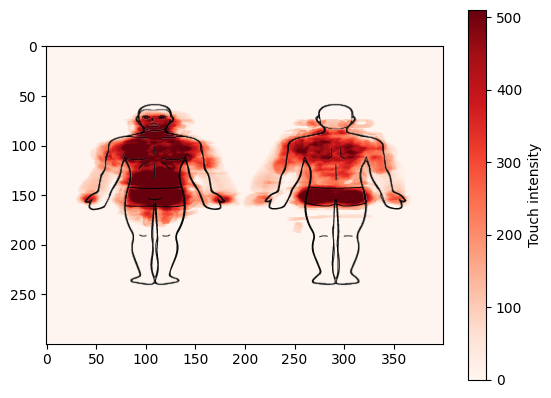

In [42]:
# Load images (target images)
target_pref = 'output/merge/Men Preferred Sex.png'
target_rec = 'output/merge/Men Received Sex.png'

if "Men" in target_pref and "Sex" in target_pref:
    output_name = 'output/Men Sex.png'
    target_outline = 'source/img/malebody400300.png'
if "Men" in target_pref and "Love" in target_pref:
    output_name = 'output/Men Love.png'
    target_outline = 'source/img/malebody400300.png'
if "Women" in target_pref and "Sex" in target_pref:
    output_name = 'output/Women Sex.png'
    target_outline = 'source/img/femalebody400300.png'
if "Women" in target_pref and "Love" in target_pref:
    output_name = 'output/Women Love.png'
    target_outline = 'source/img/femalebody400300.png'

image1 = Image.open(target_pref)  # could use .convert("RGBA")
image2 = Image.open(target_rec)
# Load body map outline
body_outline = Image.open(target_outline)

# draw_outline(image1, body_outline)
# draw_outline(image2, body_outline)

# We want to compare front against front, and back against back
front1 = image1.crop((0, 0, 400, 300))
back1 = image1.crop((400, 0, 800, 300))

front2 = image2.crop((0, 0, 400, 300))
back2 = image2.crop((400, 0, 800, 300))

# Convert to numpy arrays, this will help us to navigate through the data with ease, using numpy instead
# of PIL of CV libraries
arr1 = np.array(front1)
arr2 = np.array(front2)
arr3 = np.array(back1)
arr4 = np.array(back2)

match_percentage = count_match(arr1, arr2)
print(f'{match_percentage:.2f}%', "pixels are matched between Image 1 and Image 2")

# Extract alpha chanel (transparency)
# Front
alpha1 = arr1[:, :, 3].astype(float)
alpha2 = arr2[:, :, 3].astype(float)
# Back
alpha3 = arr3[:, :, 3].astype(float)
alpha4 = arr4[:, :, 3].astype(float)

# Compute absolute differences (not sure about this part)
front_map = np.abs(alpha1 + alpha2)  # This acts as a "difference significance" map
back_map = np.abs(alpha3 + alpha4)
plot_heatmap(front_map, back_map, body_outline, output_name)

# Calculate t-test for t_map and p_map values.
# Use any arr shape since they are all the same in shape.
t_map_front = np.zeros(shape=alpha1.shape)
p_map_front = np.zeros(shape=alpha1.shape)
#
t_map_back = np.zeros(shape=alpha1.shape)
p_map_back = np.zeros(shape=alpha1.shape)

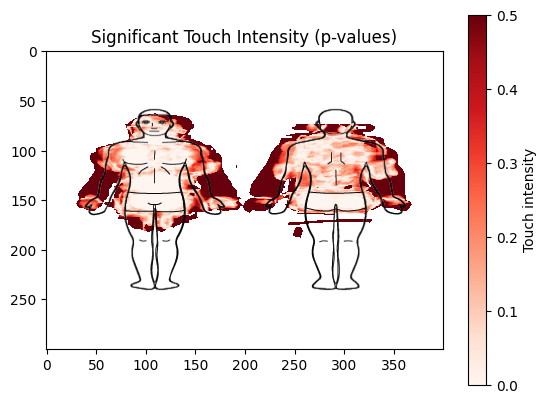

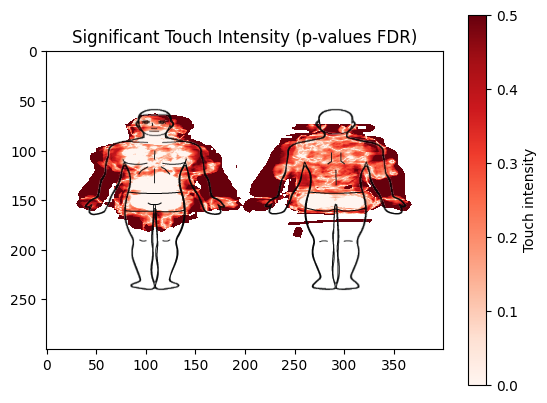

In [43]:
for i in range(front_map.shape[0]):
    for j in range(front_map.shape[1]):
        t_map_front[i, j], p_map_front[i, j] = calculate_t(alpha1[i, j], alpha2[i, j])

time.sleep(0.5)  # Just as caution

for i in range(front_map.shape[0]):
    for j in range(front_map.shape[1]):
        t_map_back[i, j], p_map_back[i, j] = calculate_t(alpha3[i, j], alpha4[i, j])

t_map = np.hstack((t_map_front, t_map_back))
p_map = np.hstack((p_map_front, p_map_back))

plot_t_p_map(t_map, p_map, body_outline, 300, 800)